In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import pylab as plt
from sklearn.metrics import jaccard_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
pd.set_option('display.max_colwidth', 200)

In [12]:
# Read folder paths from the file
with open('../dirs.txt', 'r') as f:
    lines = [line.strip() for line in f]

# Paths to save figures
path_figures = lines[1]
path_hsbm = "../hsbm/"
path_bert = "../bertopic/"

In [13]:


def create_keywords(df, group="topic_level_0"):
    """
    Create keywords for each topic using ClassTfidfTransformer (same as BERTopic).

    Args:
        df (pd.DataFrame): DataFrame containing the text data and topic labels.
        group (str): Column name to group by for topic labels.
    Returns:
        dict: Dictionary with topic labels as keys and lists of keywords as values.

    """
    # Add list of preprocessed results
    corpus = df.groupby(group)["preprocessed_text"].agg(lambda x: " ".join(x))
    corpus_index = corpus.index
    corpus = corpus.values
    
    vectorizer = CountVectorizer()
    ctfidf = ClassTfidfTransformer(reduce_frequent_words=True)
    X = vectorizer.fit_transform(corpus)
    ctfidf_matrix = ctfidf.fit_transform(X)
    
    
    #Representative words
    feature_names = vectorizer.get_feature_names_out()
    
    top_words_per_class = {}
    for doc_idx, doc in enumerate(ctfidf_matrix):
        # Convert the row to a dense array and get the indices of the top 5 values
        top_n_idx = np.argsort(doc.toarray().flatten())[-10:][: : -1]
        
        # Get the corresponding feature names for these indices
        top_features = [feature_names[i] for i in top_n_idx]
        
        # Store the top words for this document
        top_words_per_class[corpus_index[doc_idx]] = top_features

    
    return top_words_per_class

def add_keywords(df):
    """
    Add keywords to the DataFrame based on the topic labels.
    Args:
        df (pd.DataFrame): DataFrame containing the text data and topic labels.
    Returns:
        pd.DataFrame: DataFrame with an additional column for keywords.
    """
    # Create keywords for each topic
    topics_keywords_dict_ = create_keywords(df, "topic")
    # Save keywords
    df_keywords = pd.DataFrame()
    for i, keywords in topics_keywords_dict_.items():
        keywords_str = ', '.join(keywords)
        df_keywords = pd.concat([df_keywords, pd.DataFrame([[i, keywords_str]])], ignore_index=True)
    df_keywords = df_keywords.rename(columns={0:'topic', 1:'keywords'})
    df = pd.merge(df, df_keywords, on="topic")
    return df 
    

### Topic Modeling Comparison and Analysis

Processes and analyzes topic modeling results from two different methods: HSBM and BERTopic.

It compares the topics generated by both methods and evaluates their alignment.
* Loading datasets for HSBM and BERTopic results.
* Adding keywords to topics using cTFIDF 
* Comparing topics from both methods using confusion matrices and clustering heatmaps.
* Mapping topics to meaningful labels for better interpretability.
* Generating statistics and exporting samples of agreements and disagreements between the methods.
* Saving the final topics for further analysis or reporting.

In [14]:
## Loading datasets for HSBM and BERTopic results.

method = "embeddings"#"["c-tf-idf", "distributions", "embeddings"]
n_top = [20, 30, 40]

# HSBM topics
df2 = pd.read_csv(f'{path_hsbm}/data_processing/'+'stories.tsv.gz', sep='\t', compression="gzip")
df2["topic_level_1"] = df2["topic_level_1"].fillna(-1).astype(int)
print(len(df2["topic_level_1"].unique()))

# Compare to merged BERTopic topics (low correlation)
for i in n_top:
    df1 = pd.read_csv(f"{path_bert}/data_processing/stories_outliers_{method}_ntopics_{i}.tsv.gz", sep='\t', compression="gzip", usecols=["story_id", "topic"])
    print(method, i, accuracy_score(df1["topic"], df2["topic_level_1"]))

21
embeddings 20 0.05726277109301823
embeddings 30 0.05364219324158801
embeddings 40 0.04697744794293537


In [15]:
#Loading the data
df_hsbm = pd.read_csv(f'{path_hsbm}/data_processing/'+'stories.tsv.gz', sep='\t', compression="gzip")
df_bert40 = pd.read_csv(f"{path_bert}/data_processing/stories_outliers_embeddings_ntopics_40.tsv.gz", sep='\t', compression="gzip")
df_bert30 = pd.read_csv(f"{path_bert}/data_processing/stories_outliers_embeddings_ntopics_30.tsv.gz", sep='\t', compression="gzip")
df_bert20 = pd.read_csv(f"{path_bert}/data_processing/stories_outliers_embeddings_ntopics_20.tsv.gz", sep='\t', compression="gzip")


In [16]:
# Adding keywords to topics using cTFIDF (the merged topics do not have that by default) 
df_bert40 = add_keywords(df_bert40)
df_bert30 = add_keywords(df_bert30)
df_bert20 = add_keywords(df_bert20)



In [17]:
# Count number of stories per topic
df_bert_t40 = df_bert40.groupby(["topic", "keywords"])["story_id"].count().reset_index()
df_bert_t40.columns = ["Topic", "Name", "Count"]
df_bert_t30 = df_bert30.groupby(["topic", "keywords"])["story_id"].count().reset_index()
df_bert_t30.columns = ["Topic", "Name", "Count"]
df_bert_t20 = df_bert20.groupby(["topic", "keywords"])["story_id"].count().reset_index()
df_bert_t20.columns = ["Topic", "Name", "Count"]

df_bert_t30

,Topic,Name,Count
0,-1,"zylon, empadronar, empadronas, empadronen, empalado, empalador, empalados, empalagosas, empalamiento, empalando",6
1,0,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554
2,1,"ucrania, rusia, guerra, ruso, rusa, putin, rusos, otan, militar, ucraniano",4094
3,2,"pelicula, cine, musica, peliculas, historia, the, cancion, su, obra, como",4261
4,3,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691
5,4,"inflacion, banco, euros, pensiones, millones, bancos, tipos, economia, deuda, precios",2410
6,5,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015
7,6,"policia, detenido, hombre, mujer, agentes, victima, joven, guardia, anos, nacional",1927
8,7,"energia, coches, electricos, electricidad, electrico, gas, baterias, vehiculos, hidrogeno, renovables",1702
9,8,"temperaturas, calor, grados, temperatura, incendios, climatico, incendio, cambio, forestales, clima",1342


In [ ]:
# Also for HSBM
df_hsmb_t = df_hsbm.groupby(["topic_level_1", "topic_keywords_level_1"])["story_id"].count().reset_index()
df_hsmb_t.columns = ["Topic", "Name", "Count"]
df_hsmb_t

In [26]:
# Merge HSBM and BERTopic topics
df = pd.merge(df_hsbm[["story_id", "text", "topic_level_1"]], df_bert30[["story_id", "topic"]])
df.shape

(55516, 4)

Text(1126.2777777777778, 0.5, 'HSBM topic')

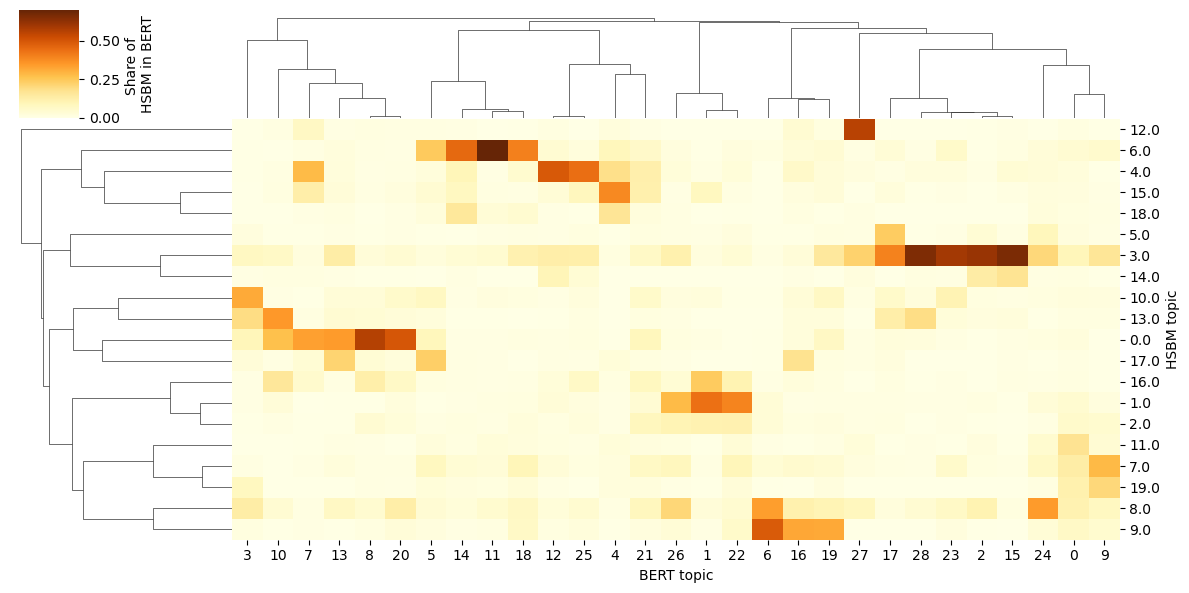

In [ ]:
# Share of each berttopic topic included in each hsbm topic
confusion = pd.crosstab(df["topic_level_1"], df["topic"], normalize=1) 
cm = sns.clustermap(confusion, figsize=(12,6), cmap="YlOrBr", metric="cosine", cbar_kws={'label': 'Share of \nHSBM in BERT'})#, xlabel="BERT topic", ylabel="HSBM topic")

cm.ax_heatmap.set_xlabel("BERT topic")
cm.ax_heatmap.set_ylabel("HSBM topic")

plt.savefig(path_figures+"confusion_matrix.pdf", bbox_inches='tight')



In [28]:
# Functions to compare HSBM and BERTopic topics to understand the overlap
def merge_with_hsmb(df, topics_bert):
    x = df.loc[df["topic"].isin(topics_bert), ["topic_level_1"]].value_counts().reset_index()
    x.columns = ["Topic", "Count_bert"]
    x = pd.merge(x, df_hsmb_t)
    x["Fraction_topic"] = x["Count_bert"]/x["Count"]
    return x
def merge_with_bert(df, topics_hsbm, df_bert_t):
    x = df.loc[df["topic_level_1"].isin(topics_hsbm), ["topic"]].value_counts().reset_index()
    x.columns = ["Topic", "Count_hsbm"]
    x = pd.merge(x, df_bert_t)
    x["Fraction_topic"] = x["Count_hsbm"]/x["Count"]
    return x

In [29]:
# Example: Russia 1_ucrania_rusia_ruso_guerra
display(merge_with_hsmb(df, [1]).head(5))

,Topic,Count_bert,Name,Count,Fraction_topic
0,1.0,1787,"['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']",3415,0.523280
1,16.0,993,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.458872
2,2.0,447,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.220959
3,15.0,324,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.137521
4,8.0,117,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.024035


In [30]:
# Example: Russia 1_ucrania_rusia_ruso_guerra and 16 estadounidense_china_wagner_rusia combined
display(merge_with_bert(df, [1, 16], df_bert_t30).head(5))

,Topic,Count_hsbm,Name,Count,Fraction_topic
0,1,2780,"ucrania, rusia, guerra, ruso, rusa, putin, rusos, otan, militar, ucraniano",4094,0.679043
1,0,1015,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.057822
2,22,410,"trump, donald, expresidente, biden, documentos, unidos, estados, periodista, assange, investigacion",814,0.503686
3,10,253,"espacial, nasa, luna, cohete, mision, tierra, orbita, espacio, planeta, nave",1368,0.184942
4,8,174,"temperaturas, calor, grados, temperatura, incendios, climatico, incendio, cambio, forestales, clima",1342,0.129657


In [ ]:
for i in range(29):
    print(i, df_bert_t30.loc[df_bert_t30["Topic"]==i, "Name"].values[0])
    
    display(merge_with_hsmb(df, [i]).head(8))

    

0 madrid, le, las, se, es, como, lo, para, con, vox, gobierno, por, elecciones, del, su, al, no, ha, partido, pp


,Topic,Count_bert,Name,Count,Fraction_topic
0,11.0,3019,"['sanchez', 'ayuso', 'alberto', 'nunez', 'electoral', 'elección', 'partido', 'vox', 'feijoo', 'pp']",3532,0.854757
1,7.0,2321,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.604112
2,19.0,2053,"['bildu', 'partido', 'igualdad', 'congreso', 'tribunal', 'constitucional', 'pp', 'montero', 'psoe', 'ley']",2935,0.699489
3,8.0,1921,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.394618
4,3.0,1588,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.204639
5,9.0,1171,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.381061
6,2.0,960,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.474543
7,1.0,793,"['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']",3415,0.232211


1 unidos, ucranianos, defensa, estados, rusas, kiev, invasion, moscu, fuerzas, ejercito, ucraniano, militar, otan, rusos, putin, rusa, ruso, guerra, rusia, ucrania


,Topic,Count_bert,Name,Count,Fraction_topic
0,1.0,1787,"['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']",3415,0.523280
1,16.0,993,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.458872
2,2.0,447,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.220959
3,15.0,324,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.137521
4,8.0,117,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.024035
5,10.0,97,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.048283
6,3.0,78,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.010052
7,0.0,40,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.011412


2 serie, con, una, juegos, mas, arte, libros, banda, es, juego, como, obra, su, cancion, the, historia, peliculas, musica, cine, pelicula


,Topic,Count_bert,Name,Count,Fraction_topic
0,3.0,2610,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.336340
1,14.0,571,"['software', 'apple', 'pc', 'ordenador', 'windows', 'google', 'of', 'videojuego', 'the', 'juego']",1281,0.445746
2,8.0,458,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.094084
3,5.0,161,"['aviar', 'emerito', 'gripe', 'juan', 'felipe', 'virus', 'covid', 'carlos', 'rey', 'premio']",935,0.172193
4,13.0,81,"['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']",1776,0.045608
5,11.0,73,"['sanchez', 'ayuso', 'alberto', 'nunez', 'electoral', 'elección', 'partido', 'vox', 'feijoo', 'pp']",3532,0.020668
6,10.0,62,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.030861
7,7.0,60,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.015617


3 gatos, como, ciudad, una, se, un, piedra, romano, mas, aves, siglo, restos, caza, perro, arqueologos, especie, especies, perros, animal, animales


,Topic,Count_bert,Name,Count,Fraction_topic
0,10.0,850,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.423096
1,13.0,520,"['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']",1776,0.292793
2,8.0,353,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.072514
3,0.0,244,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.069615
4,19.0,217,"['bildu', 'partido', 'igualdad', 'congreso', 'tribunal', 'constitucional', 'pp', 'montero', 'psoe', 'ley']",2935,0.073935
5,3.0,203,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.026160
6,17.0,76,"['regadio', 'agricultor', 'parque', 'alimento', 'sequia', 'supermercado', 'donana', 'precio', 'tren', 'agua']",1499,0.050700
7,5.0,47,"['aviar', 'emerito', 'gripe', 'juan', 'felipe', 'virus', 'covid', 'carlos', 'rey', 'premio']",935,0.050267


4 espana, bank, impuestos, bce, banca, subida, pib, impuesto, ano, interes, precios, deuda, economia, tipos, bancos, millones, pensiones, euros, banco, inflacion


,Topic,Count_bert,Name,Count,Fraction_topic
0,15.0,927,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.393463
1,4.0,444,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.152473
2,18.0,399,"['gobierno', 'galicia', 'xunta', 'fiscal', 'reforma', 'empleo', 'pensión', 'euros', 'impuesto', 'salario']",1119,0.356568
3,6.0,215,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.055642
4,11.0,63,"['sanchez', 'ayuso', 'alberto', 'nunez', 'electoral', 'elección', 'partido', 'vox', 'feijoo', 'pp']",3532,0.017837
5,17.0,63,"['regadio', 'agricultor', 'parque', 'alimento', 'sequia', 'supermercado', 'donana', 'precio', 'tren', 'agua']",1499,0.042028
6,7.0,52,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.013535
7,12.0,51,"['gas', 'mwh', 'ohio', 'fontdevila', 'grafico', 'bernardo', 'precio', 'vergara', 'satirico', 'vineta']",642,0.079439


5 sequia, las, se, donana, madrid, ley, para, zonas, residuos, propietarios, ayuntamiento, alquileres, vecinos, parque, contaminacion, pisos, viviendas, alquiler, agua, vivienda


,Topic,Count_bert,Name,Count,Fraction_topic
0,6.0,490,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.126812
1,17.0,462,"['regadio', 'agricultor', 'parque', 'alimento', 'sequia', 'supermercado', 'donana', 'precio', 'tren', 'agua']",1499,0.308205
2,0.0,176,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.050214
3,7.0,160,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.041645
4,10.0,150,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.074664
5,15.0,86,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.036503
6,8.0,78,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.016023
7,19.0,51,"['bildu', 'partido', 'igualdad', 'congreso', 'tribunal', 'constitucional', 'pp', 'montero', 'psoe', 'ley']",2935,0.017376


6 tras, presunto, mossos, sido, arma, agresion, hechos, dos, fue, civil, nacional, anos, guardia, joven, victima, agentes, mujer, hombre, detenido, policia


,Topic,Count_bert,Name,Count,Fraction_topic
0,9.0,936,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.304588
1,8.0,656,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.134758
2,7.0,73,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.019001
3,2.0,68,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.033613
4,1.0,67,"['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']",3415,0.019619
5,6.0,25,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.006470
6,3.0,20,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.002577
7,16.0,14,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.006470


7 energias, solares, energetica, solar, precio, mercado, electrica, produccion, coche, emisiones, renovables, hidrogeno, vehiculos, baterias, gas, electrico, electricidad, electricos, coches, energia


,Topic,Count_bert,Name,Count,Fraction_topic
0,0.0,568,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.162054
1,4.0,477,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.163805
2,15.0,214,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.090832
3,12.0,124,"['gas', 'mwh', 'ohio', 'fontdevila', 'grafico', 'bernardo', 'precio', 'vergara', 'satirico', 'vineta']",642,0.193146
4,16.0,92,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.042514
5,17.0,62,"['regadio', 'agricultor', 'parque', 'alimento', 'sequia', 'supermercado', 'donana', 'precio', 'tren', 'agua']",1499,0.041361
6,3.0,30,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.003866
7,14.0,19,"['software', 'apple', 'pc', 'ordenador', 'windows', 'google', 'of', 'videojuego', 'the', 'juego']",1281,0.014832


8 calido, climatica, mas, ola, lluvias, fuego, record, calentamiento, hielo, nieve, clima, forestales, cambio, incendio, climatico, incendios, temperatura, grados, calor, temperaturas


,Topic,Count_bert,Name,Count,Fraction_topic
0,0.0,757,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.215977
1,16.0,167,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.077172
2,8.0,61,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.012531
3,2.0,58,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.028670
4,17.0,51,"['regadio', 'agricultor', 'parque', 'alimento', 'sequia', 'supermercado', 'donana', 'precio', 'tren', 'agua']",1499,0.034023
5,13.0,51,"['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']",1776,0.028716
6,10.0,42,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.020906
7,3.0,37,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.004768


9 feminista, es, no, prostitucion, derechos, derecho, si, hombres, sexuales, embarazo, mujer, sexual, sexo, trans, genero, violencia, igualdad, aborto, ley, mujeres


,Topic,Count_bert,Name,Count,Fraction_topic
0,7.0,511,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.133004
1,19.0,375,"['bildu', 'partido', 'igualdad', 'congreso', 'tribunal', 'constitucional', 'pp', 'montero', 'psoe', 'ley']",2935,0.127768
2,3.0,292,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.037629
3,8.0,140,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.028759
4,6.0,94,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.024327
5,9.0,86,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.027986
6,2.0,84,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.041522
7,11.0,70,"['sanchez', 'ayuso', 'alberto', 'nunez', 'electoral', 'elección', 'partido', 'vox', 'feijoo', 'pp']",3532,0.019819


10 webb, planetas, lunar, estrellas, lanzamiento, satelites, telescopio, vuelo, universo, avion, nave, planeta, espacio, orbita, tierra, mision, cohete, luna, nasa, espacial


,Topic,Count_bert,Name,Count,Fraction_topic
0,13.0,479,"['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']",1776,0.269707
1,0.0,368,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.104993
2,16.0,215,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.099353
3,3.0,93,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.011985
4,8.0,59,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.012120
5,1.0,38,"['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']",3415,0.011127
6,15.0,15,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.006367
7,14.0,15,"['software', 'apple', 'pc', 'ordenador', 'windows', 'google', 'of', 'videojuego', 'the', 'juego']",1281,0.011710


11 comunidad, madrid, centros, sanitaria, sindicato, publica, urgencias, sanitario, profesionales, hospitales, sanitarios, medico, pacientes, salud, atencion, primaria, hospital, medicos, huelga, sanidad


,Topic,Count_bert,Name,Count,Fraction_topic
0,6.0,959,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.248188
1,8.0,66,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.013558
2,3.0,62,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.007990
3,18.0,46,"['gobierno', 'galicia', 'xunta', 'fiscal', 'reforma', 'empleo', 'pensión', 'euros', 'impuesto', 'salario']",1119,0.041108
4,7.0,44,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.011452
5,11.0,34,"['sanchez', 'ayuso', 'alberto', 'nunez', 'electoral', 'elección', 'partido', 'vox', 'feijoo', 'pp']",3532,0.009626
6,10.0,25,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.012444
7,19.0,19,"['bildu', 'partido', 'igualdad', 'congreso', 'tribunal', 'constitucional', 'pp', 'montero', 'psoe', 'ley']",2935,0.006474


12 movil, amazon, empresa, informacion, usuario, apple, cuentas, redes, compania, google, web, netflix, internet, red, plataforma, datos, usuarios, elon, musk, twitter


,Topic,Count_bert,Name,Count,Fraction_topic
0,4.0,793,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.272321
1,3.0,205,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.026418
2,14.0,156,"['software', 'apple', 'pc', 'ordenador', 'windows', 'google', 'of', 'videojuego', 'the', 'juego']",1281,0.121780
3,6.0,67,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.017340
4,15.0,55,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.023345
5,7.0,52,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.013535
6,1.0,49,"['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']",3415,0.014348
7,8.0,41,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.008422


13 tortilla, restaurante, patatas, pan, azucar, bebidas, cesta, cerveza, dieta, alimentacion, consumo, comer, aceite, precios, leche, carne, comida, supermercados, productos, alimentos


,Topic,Count_bert,Name,Count,Fraction_topic
0,0.0,418,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.119258
1,17.0,261,"['regadio', 'agricultor', 'parque', 'alimento', 'sequia', 'supermercado', 'donana', 'precio', 'tren', 'agua']",1499,0.174116
2,3.0,160,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.020619
3,8.0,88,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.018077
4,13.0,52,"['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']",1776,0.029279
5,10.0,37,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.018417
6,15.0,36,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.015280
7,4.0,28,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.009615


14 horas, convenio, jornada, salarios, trabajador, sindicatos, salarial, paro, plantilla, laborales, despidos, empresas, empresa, salario, despido, empleados, empleo, trabajo, laboral, trabajadores


,Topic,Count_bert,Name,Count,Fraction_topic
0,6.0,622,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.160973
1,18.0,210,"['gobierno', 'galicia', 'xunta', 'fiscal', 'reforma', 'empleo', 'pensión', 'euros', 'impuesto', 'salario']",1119,0.187668
2,4.0,130,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.044643
3,15.0,108,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.045840
4,3.0,49,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.006314
5,7.0,49,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.012754
6,8.0,34,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.006984
7,19.0,25,"['bildu', 'partido', 'igualdad', 'congreso', 'tribunal', 'constitucional', 'pp', 'montero', 'psoe', 'ley']",2935,0.008518


15 generativa, web, herramienta, chatbot, codigo, herramientas, software, crear, modelos, windows, microsoft, tecnologia, lenguaje, google, openai, gpt, ia, chatgpt, inteligencia, artificial


,Topic,Count_bert,Name,Count,Fraction_topic
0,3.0,795,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.102448
1,14.0,206,"['software', 'apple', 'pc', 'ordenador', 'windows', 'google', 'of', 'videojuego', 'the', 'juego']",1281,0.160812
2,4.0,44,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.015110
3,13.0,28,"['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']",1776,0.015766
4,8.0,17,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.003492
5,6.0,15,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.003882
6,16.0,13,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.006007
7,0.0,12,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.003424


16 pasajeros, renfe, kmh, autobus, via, transportes, ferroviaria, camion, vehiculos, carretera, conductores, transporte, velocidad, trafico, conductor, accidente, tren, coche, trenes, vehiculo


,Topic,Count_bert,Name,Count,Fraction_topic
0,9.0,357,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.116173
1,17.0,196,"['regadio', 'agricultor', 'parque', 'alimento', 'sequia', 'supermercado', 'donana', 'precio', 'tren', 'agua']",1499,0.130754
2,8.0,128,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.026294
3,4.0,69,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.023695
4,7.0,57,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.014836
5,12.0,46,"['gas', 'mwh', 'ohio', 'fontdevila', 'grafico', 'bernardo', 'precio', 'vergara', 'satirico', 'vineta']",642,0.071651
6,10.0,34,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.016924
7,6.0,34,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.008799


17 sintomas, cientificos, muertes, infecciones, vacunacion, investigadores, estudio, pandemia, casos, coronavirus, aviar, gripe, celulas, vacuna, enfermedades, vacunas, enfermedad, virus, covid, cancer


,Topic,Count_bert,Name,Count,Fraction_topic
0,3.0,338,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.043557
1,5.0,203,"['aviar', 'emerito', 'gripe', 'juan', 'felipe', 'virus', 'covid', 'carlos', 'rey', 'premio']",935,0.217112
2,13.0,108,"['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']",1776,0.060811
3,10.0,49,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.024390
4,6.0,30,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.007764
5,0.0,20,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.005706
6,15.0,20,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.008489
7,8.0,17,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.003492


18 clase, docente, padres, escolares, ensenanza, clases, educativo, escuelas, colegio, docentes, curso, universidad, escolar, alumnado, centros, escuela, profesores, estudiantes, alumnos, educacion


,Topic,Count_bert,Name,Count,Fraction_topic
0,6.0,298,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.077122
1,3.0,84,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.010825
2,7.0,69,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.017959
3,8.0,54,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.011093
4,9.0,49,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.015945
5,4.0,35,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.012019
6,18.0,34,"['gobierno', 'galicia', 'xunta', 'fiscal', 'reforma', 'empleo', 'pensión', 'euros', 'impuesto', 'salario']",1119,0.030384
7,19.0,24,"['bildu', 'partido', 'igualdad', 'congreso', 'tribunal', 'constitucional', 'pp', 'montero', 'psoe', 'ley']",2935,0.008177


19 operacion, sustancia, productos, sobredosis, medicamento, medicinal, hachis, farmacias, policia, fentanilo, estupefacientes, sustancias, consumo, kilos, marihuana, medicamentos, droga, drogas, cannabis, cocaina


,Topic,Count_bert,Name,Count,Fraction_topic
0,9.0,134,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.043606
1,3.0,64,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.008247
2,8.0,43,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.008833
3,0.0,31,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.008845
4,10.0,31,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.015431
5,7.0,18,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.004685
6,6.0,17,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.004400
7,4.0,12,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.004121


20 titan, naufragio, velero, pesca, orcas, agua, aguas, sumergible, buques, costa, rescate, bordo, titanic, barcos, puerto, submarino, embarcacion, mar, buque, barco


,Topic,Count_bert,Name,Count,Fraction_topic
0,0.0,329,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.093866
1,8.0,86,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.017666
2,16.0,44,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.020333
3,10.0,36,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.017919
4,3.0,27,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.003479
5,13.0,19,"['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']",1776,0.010698
6,9.0,18,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.005857
7,2.0,17,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.008403


21 jovenes, millones, porcentaje, mexico, natalidad, migracion, mas, refugiados, inmigracion, frontera, espana, personas, pobreza, habitantes, pais, paises, asilo, inmigrantes, poblacion, migrantes


,Topic,Count_bert,Name,Count,Fraction_topic
0,4.0,78,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.026786
1,15.0,77,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.032683
2,0.0,56,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.015977
3,2.0,54,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.026693
4,8.0,53,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.010887
5,16.0,52,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.024030
6,7.0,45,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.011713
7,3.0,43,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.005541


22 juez, contra, estadounidense, sobre, presidente, cargos, capitolio, joe, wikileaks, hunter, investigacion, assange, periodista, estados, unidos, documentos, biden, expresidente, donald, trump


,Topic,Count_bert,Name,Count,Fraction_topic
0,1.0,322,"['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']",3415,0.094290
1,2.0,92,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.045477
2,16.0,88,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.040665
3,7.0,75,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.019521
4,9.0,47,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.015295
5,8.0,37,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.007601
6,3.0,31,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.003995
7,11.0,27,"['sanchez', 'ayuso', 'alberto', 'nunez', 'electoral', 'elección', 'partido', 'vox', 'feijoo', 'pp']",3532,0.007644


23 miedo, si, mas, ser, son, te, suicidios, lo, nos, no, psicologia, me, personas, es, ansiedad, salud, depresion, vida, mental, suicidio


,Topic,Count_bert,Name,Count,Fraction_topic
0,3.0,427,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.055026
1,10.0,76,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.037830
2,8.0,49,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.010066
3,6.0,42,"['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']",3864,0.010870
4,7.0,41,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.010672
5,13.0,18,"['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']",1776,0.010135
6,4.0,15,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.005151
7,9.0,12,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.003905


24 cancer, este, conocido, cantante, actriz, vida, fue, ha, familia, edad, su, actor, muerte, fallecimiento, muerto, anos, fallecio, murio, ferrovial, fallecido


,Topic,Count_bert,Name,Count,Fraction_topic
0,8.0,170,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.034922
1,3.0,101,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.013015
2,5.0,44,"['aviar', 'emerito', 'gripe', 'juan', 'felipe', 'virus', 'covid', 'carlos', 'rey', 'premio']",935,0.047059
3,7.0,34,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.008850
4,11.0,23,"['sanchez', 'ayuso', 'alberto', 'nunez', 'electoral', 'elección', 'partido', 'vox', 'feijoo', 'pp']",3532,0.006512
5,9.0,17,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.005532
6,4.0,16,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.005495
7,1.0,15,"['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']",3415,0.004392


25 blockchain, millones, oro, transacciones, inversores, banco, btc, dinero, criptomoneda, ftx, cripto, valor, billetes, binance, dolares, dolar, monedas, moneda, bitcoin, criptomonedas


,Topic,Count_bert,Name,Count,Fraction_topic
0,4.0,163,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.055975
1,3.0,46,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.005928
2,15.0,31,"['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']",2356,0.013158
3,16.0,25,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.011553
4,8.0,17,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.003492
5,14.0,14,"['software', 'apple', 'pc', 'ordenador', 'windows', 'google', 'of', 'videojuego', 'the', 'juego']",1281,0.010929
6,9.0,9,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.002929
7,2.0,9,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.004449


26 ropa, islam, iranies, afganas, protestas, mujer, islamica, islamico, kabul, irani, hiyab, mahsa, talibanes, velo, amini, taliban, qatar, afganistan, mujeres, iran


,Topic,Count_bert,Name,Count,Fraction_topic
0,1.0,91,"['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']",3415,0.026647
1,8.0,68,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.013969
2,3.0,38,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.004897
3,2.0,33,"['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']",2023,0.016312
4,7.0,27,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.007028
5,16.0,12,"['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']",2164,0.005545
6,9.0,11,"['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']",3073,0.003580
7,4.0,8,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.002747


27 me, entradilla, alex, letras, llovia, sans, comic, es, leerlo, alargamiento, frenchy, escarcha, ser, menos, hey, debe, demasiado, texto, corto, caracteres


,Topic,Count_bert,Name,Count,Fraction_topic
0,12.0,68,"['gas', 'mwh', 'ohio', 'fontdevila', 'grafico', 'bernardo', 'precio', 'vergara', 'satirico', 'vineta']",642,0.105919
1,3.0,27,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.003479
2,8.0,10,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.002054
3,11.0,3,"['sanchez', 'ayuso', 'alberto', 'nunez', 'electoral', 'elección', 'partido', 'vox', 'feijoo', 'pp']",3532,0.000849
4,4.0,2,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.000687
5,7.0,2,"['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']",3842,0.000521
6,14.0,2,"['software', 'apple', 'pc', 'ordenador', 'windows', 'google', 'of', 'videojuego', 'the', 'juego']",1281,0.001561
7,0.0,1,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.000285


28 visual, como, puede, estudio, humanos, magnetica, recuerdos, es, nervioso, circuitos, olfato, philips, nuestro, humano, cerebrales, memoria, cerebral, vision, neuronas, cerebro


,Topic,Count_bert,Name,Count,Fraction_topic
0,3.0,197,"['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']",7760,0.025387
1,13.0,57,"['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']",1776,0.032095
2,8.0,13,"['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']",4868,0.002671
3,0.0,6,"['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']",3505,0.001712
4,4.0,6,"['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']",2912,0.002060
5,10.0,6,"['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']",2009,0.002987
6,14.0,4,"['software', 'apple', 'pc', 'ordenador', 'windows', 'google', 'of', 'videojuego', 'the', 'juego']",1281,0.003123
7,1.0,2,"['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']",3415,0.000586


In [31]:
# Same but for HSBM topics
for i in range(20):
    print(i, df_hsmb_t.loc[df_hsmb_t["Topic"]==i, "Name"].values[0])
    display(merge_with_bert(df, [i], df_bert_t30).head(8))

0 ['grado', 'mas', 'solar', 'mar', 'espacial', 'agua', 'climatico', 'calor', 'energia', 'temperatura']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,8,757,"temperaturas, calor, grados, temperatura, incendios, climatico, incendio, cambio, forestales, clima",1342,0.564083
1,7,568,"energia, coches, electricos, electricidad, electrico, gas, baterias, vehiculos, hidrogeno, renovables",1702,0.333725
2,13,418,"alimentos, productos, supermercados, comida, carne, leche, precios, aceite, comer, consumo",1209,0.345740
3,10,368,"espacial, nasa, luna, cohete, mision, tierra, orbita, espacio, planeta, nave",1368,0.269006
4,0,349,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.019882
5,20,329,"barco, buque, mar, embarcacion, submarino, puerto, barcos, titanic, bordo, rescate",659,0.499241
6,3,244,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691,0.090673
7,5,176,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015,0.087345


1 ['invasion', 'otan', 'militar', 'putin', 'trump', 'ucraniano', 'rusia', 'guerra', 'ruso', 'ucrania']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,1,1787,"ucrania, rusia, guerra, ruso, rusa, putin, rusos, otan, militar, ucraniano",4094,0.436492
1,0,793,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.045175
2,22,322,"trump, donald, expresidente, biden, documentos, unidos, estados, periodista, assange, investigacion",814,0.395577
3,26,91,"iran, mujeres, afganistan, qatar, taliban, amini, velo, talibanes, mahsa, hiyab",325,0.280000
4,6,67,"policia, detenido, hombre, mujer, agentes, victima, joven, guardia, anos, nacional",1927,0.034769
5,12,49,"twitter, musk, elon, usuarios, datos, plataforma, red, internet, netflix, web",1614,0.030359
6,2,47,"pelicula, cine, musica, peliculas, historia, the, cancion, su, obra, como",4261,0.011030
7,10,38,"espacial, nasa, luna, cohete, mision, tierra, orbita, espacio, planeta, nave",1368,0.027778


2 ['civil', 'peru', 'presidente', 'brasil', 'derechos', 'israeli', 'bolsonaro', 'humanos', 'palestino', 'israel']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,0,960,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.054688
1,1,447,"ucrania, rusia, guerra, ruso, rusa, putin, rusos, otan, militar, ucraniano",4094,0.109184
2,22,92,"trump, donald, expresidente, biden, documentos, unidos, estados, periodista, assange, investigacion",814,0.113022
3,9,84,"mujeres, ley, aborto, igualdad, violencia, genero, trans, sexo, sexual, mujer",1810,0.046409
4,6,68,"policia, detenido, hombre, mujer, agentes, victima, joven, guardia, anos, nacional",1927,0.035288
5,8,58,"temperaturas, calor, grados, temperatura, incendios, climatico, incendio, cambio, forestales, clima",1342,0.043219
6,21,54,"migrantes, poblacion, inmigrantes, asilo, paises, pais, habitantes, pobreza, personas, espana",643,0.083981
7,26,33,"iran, mujeres, afganistan, qatar, taliban, amini, velo, talibanes, mahsa, hiyab",325,0.101538


3 ['tener', 'vida', 'hacer', 'mas', 'ser', 'historia', 'inteligencia', 'ia', 'artificial', 'pelicula']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,2,2610,"pelicula, cine, musica, peliculas, historia, the, cancion, su, obra, como",4261,0.612532
1,0,1588,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.090464
2,15,795,"artificial, inteligencia, chatgpt, ia, gpt, openai, google, lenguaje, tecnologia, microsoft",1204,0.660299
3,23,427,"suicidio, mental, vida, depresion, salud, ansiedad, es, personas, me, psicologia",719,0.593880
4,17,338,"cancer, covid, virus, enfermedad, vacunas, enfermedades, vacuna, celulas, gripe, aviar",849,0.398115
5,9,292,"mujeres, ley, aborto, igualdad, violencia, genero, trans, sexo, sexual, mujer",1810,0.161326
6,12,205,"twitter, musk, elon, usuarios, datos, plataforma, red, internet, netflix, web",1614,0.127014
7,3,203,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691,0.075437


4 ['compania', 'plataforma', 'millón', 'electrico', 'usuario', 'banco', 'elon', 'coche', 'twitter', 'musk']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,12,793,"twitter, musk, elon, usuarios, datos, plataforma, red, internet, netflix, web",1614,0.491326
1,7,477,"energia, coches, electricos, electricidad, electrico, gas, baterias, vehiculos, hidrogeno, renovables",1702,0.280259
2,4,444,"inflacion, banco, euros, pensiones, millones, bancos, tipos, economia, deuda, precios",2410,0.184232
3,0,390,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.022217
4,25,163,"criptomonedas, bitcoin, moneda, monedas, dolar, dolares, binance, billetes, valor, cripto",370,0.440541
5,14,130,"trabajadores, laboral, trabajo, empleo, empleados, despido, salario, empresa, empresas, despidos",1367,0.095099
6,21,78,"migrantes, poblacion, inmigrantes, asilo, paises, pais, habitantes, pobreza, personas, espana",643,0.121306
7,16,69,"vehiculo, trenes, coche, tren, accidente, conductor, trafico, velocidad, transporte, conductores",1111,0.062106


5 ['aviar', 'emerito', 'gripe', 'juan', 'felipe', 'virus', 'covid', 'carlos', 'rey', 'premio']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,0,298,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.016976
1,17,203,"cancer, covid, virus, enfermedad, vacunas, enfermedades, vacuna, celulas, gripe, aviar",849,0.239105
2,2,161,"pelicula, cine, musica, peliculas, historia, the, cancion, su, obra, como",4261,0.037785
3,3,47,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691,0.017466
4,24,44,"fallecido, ferrovial, murio, fallecio, anos, muerto, fallecimiento, muerte, actor, su",493,0.089249
5,1,23,"ucrania, rusia, guerra, ruso, rusa, putin, rusos, otan, militar, ucraniano",4094,0.005618
6,22,15,"trump, donald, expresidente, biden, documentos, unidos, estados, periodista, assange, investigacion",814,0.018428
7,9,13,"mujeres, ley, aborto, igualdad, violencia, genero, trans, sexo, sexual, mujer",1810,0.007182


6 ['alquiler', 'sanitario', 'hospital', 'sindicato', 'laboral', 'medico', 'huelga', 'sanidad', 'trabajador', 'vivienda']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,11,959,"sanidad, huelga, medicos, hospital, primaria, atencion, salud, pacientes, medico, sanitarios",1373,0.698471
1,0,765,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.043580
2,14,622,"trabajadores, laboral, trabajo, empleo, empleados, despido, salario, empresa, empresas, despidos",1367,0.455011
3,5,490,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015,0.243176
4,18,298,"educacion, alumnos, estudiantes, profesores, escuela, centros, alumnado, escolar, universidad, curso",743,0.401077
5,4,215,"inflacion, banco, euros, pensiones, millones, bancos, tipos, economia, deuda, precios",2410,0.089212
6,9,94,"mujeres, ley, aborto, igualdad, violencia, genero, trans, sexo, sexual, mujer",1810,0.051934
7,12,67,"twitter, musk, elon, usuarios, datos, plataforma, red, internet, netflix, web",1614,0.041512


7 ['si', 'él', 'derecho', 'jo', 'violencia', 'caso', 'mujer', 'politico', 'ayuntamiento', 'derecha']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,0,2321,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.132221
1,9,511,"mujeres, ley, aborto, igualdad, violencia, genero, trans, sexo, sexual, mujer",1810,0.282320
2,5,160,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015,0.079404
3,22,75,"trump, donald, expresidente, biden, documentos, unidos, estados, periodista, assange, investigacion",814,0.092138
4,6,73,"policia, detenido, hombre, mujer, agentes, victima, joven, guardia, anos, nacional",1927,0.037883
5,18,69,"educacion, alumnos, estudiantes, profesores, escuela, centros, alumnado, escolar, universidad, curso",743,0.092867
6,2,60,"pelicula, cine, musica, peliculas, historia, the, cancion, su, obra, como",4261,0.014081
7,16,57,"vehiculo, trenes, coche, tren, accidente, conductor, trafico, velocidad, transporte, conductores",1111,0.051305


8 ['dos', 'padre', 'él', 'jugador', 'habiar', 'mujer', 'ano', 'hombre', 'futbol', 'policia']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,0,1921,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.109434
1,6,656,"policia, detenido, hombre, mujer, agentes, victima, joven, guardia, anos, nacional",1927,0.340426
2,2,458,"pelicula, cine, musica, peliculas, historia, the, cancion, su, obra, como",4261,0.107487
3,3,353,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691,0.131178
4,24,170,"fallecido, ferrovial, murio, fallecio, anos, muerto, fallecimiento, muerte, actor, su",493,0.344828
5,9,140,"mujeres, ley, aborto, igualdad, violencia, genero, trans, sexo, sexual, mujer",1810,0.077348
6,16,128,"vehiculo, trenes, coche, tren, accidente, conductor, trafico, velocidad, transporte, conductores",1111,0.115212
7,1,117,"ucrania, rusia, guerra, ruso, rusa, putin, rusos, otan, militar, ucraniano",4094,0.028578


9 ['menor', 'victima', 'guardia', 'hombre', 'agente', 'acusado', 'detener', 'policia', 'prision', 'delito']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,0,1171,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.066708
1,6,936,"policia, detenido, hombre, mujer, agentes, victima, joven, guardia, anos, nacional",1927,0.485729
2,16,357,"vehiculo, trenes, coche, tren, accidente, conductor, trafico, velocidad, transporte, conductores",1111,0.321332
3,19,134,"cocaina, cannabis, drogas, droga, medicamentos, marihuana, kilos, consumo, sustancias, estupefacientes",421,0.318290
4,9,86,"mujeres, ley, aborto, igualdad, violencia, genero, trans, sexo, sexual, mujer",1810,0.047514
5,18,49,"educacion, alumnos, estudiantes, profesores, escuela, centros, alumnado, escolar, universidad, curso",743,0.065949
6,22,47,"trump, donald, expresidente, biden, documentos, unidos, estados, periodista, assange, investigacion",814,0.057740
7,3,40,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691,0.014864


10 ['tumba', 'yacimiento', 'imperio', 'arqueologico', 'ac', 'arqueologo', 'ciudad', 'siglo', 'antiguo', 'romano']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,3,850,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691,0.315868
1,0,347,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.019768
2,5,150,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015,0.074442
3,1,97,"ucrania, rusia, guerra, ruso, rusa, putin, rusos, otan, militar, ucraniano",4094,0.023693
4,23,76,"suicidio, mental, vida, depresion, salud, ansiedad, es, personas, me, psicologia",719,0.105702
5,2,62,"pelicula, cine, musica, peliculas, historia, the, cancion, su, obra, como",4261,0.014551
6,17,49,"cancer, covid, virus, enfermedad, vacunas, enfermedades, vacuna, celulas, gripe, aviar",849,0.057715
7,8,42,"temperaturas, calor, grados, temperatura, incendios, climatico, incendio, cambio, forestales, clima",1342,0.031297


11 ['sanchez', 'ayuso', 'alberto', 'nunez', 'electoral', 'elección', 'partido', 'vox', 'feijoo', 'pp']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,0,3019,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.171984
1,2,73,"pelicula, cine, musica, peliculas, historia, the, cancion, su, obra, como",4261,0.017132
2,9,70,"mujeres, ley, aborto, igualdad, violencia, genero, trans, sexo, sexual, mujer",1810,0.038674
3,4,63,"inflacion, banco, euros, pensiones, millones, bancos, tipos, economia, deuda, precios",2410,0.026141
4,5,49,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015,0.024318
5,11,34,"sanidad, huelga, medicos, hospital, primaria, atencion, salud, pacientes, medico, sanitarios",1373,0.024763
6,22,27,"trump, donald, expresidente, biden, documentos, unidos, estados, periodista, assange, investigacion",814,0.033170
7,12,24,"twitter, musk, elon, usuarios, datos, plataforma, red, internet, netflix, web",1614,0.014870


12 ['gas', 'mwh', 'ohio', 'fontdevila', 'grafico', 'bernardo', 'precio', 'vergara', 'satirico', 'vineta']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,0,201,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.011450
1,7,124,"energia, coches, electricos, electricidad, electrico, gas, baterias, vehiculos, hidrogeno, renovables",1702,0.072855
2,27,68,"caracteres, corto, texto, demasiado, debe, hey, menos, ser, escarcha, frenchy",122,0.557377
3,4,51,"inflacion, banco, euros, pensiones, millones, bancos, tipos, economia, deuda, precios",2410,0.021162
4,16,46,"vehiculo, trenes, coche, tren, accidente, conductor, trafico, velocidad, transporte, conductores",1111,0.041404
5,12,18,"twitter, musk, elon, usuarios, datos, plataforma, red, internet, netflix, web",1614,0.011152
6,5,18,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015,0.008933
7,8,16,"temperaturas, calor, grados, temperatura, incendios, climatico, incendio, cambio, forestales, clima",1342,0.011923


13 ['ave', 'universo', 'humano', 'estrella', 'telescopio', 'animal', 'cientifico', 'tierra', 'planeta', 'especie']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,3,520,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691,0.193237
1,10,479,"espacial, nasa, luna, cohete, mision, tierra, orbita, espacio, planeta, nave",1368,0.350146
2,0,199,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.011336
3,17,108,"cancer, covid, virus, enfermedad, vacunas, enfermedades, vacuna, celulas, gripe, aviar",849,0.127208
4,2,81,"pelicula, cine, musica, peliculas, historia, the, cancion, su, obra, como",4261,0.019010
5,28,57,"cerebro, neuronas, vision, cerebral, memoria, cerebrales, humano, nuestro, philips, olfato",300,0.190000
6,13,52,"alimentos, productos, supermercados, comida, carne, leche, precios, aceite, comer, consumo",1209,0.043011
7,8,51,"temperaturas, calor, grados, temperatura, incendios, climatico, incendio, cambio, forestales, clima",1342,0.038003


14 ['software', 'apple', 'pc', 'ordenador', 'windows', 'google', 'of', 'videojuego', 'the', 'juego']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,2,571,"pelicula, cine, musica, peliculas, historia, the, cancion, su, obra, como",4261,0.134006
1,15,206,"artificial, inteligencia, chatgpt, ia, gpt, openai, google, lenguaje, tecnologia, microsoft",1204,0.171096
2,0,193,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.010995
3,12,156,"twitter, musk, elon, usuarios, datos, plataforma, red, internet, netflix, web",1614,0.096654
4,3,22,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691,0.008175
5,7,19,"energia, coches, electricos, electricidad, electrico, gas, baterias, vehiculos, hidrogeno, renovables",1702,0.011163
6,10,15,"espacial, nasa, luna, cohete, mision, tierra, orbita, espacio, planeta, nave",1368,0.010965
7,14,14,"trabajadores, laboral, trabajo, empleo, empleados, despido, salario, empresa, empresas, despidos",1367,0.010241


15 ['economia', 'trimestre', 'euros', 'subida', 'petroleo', 'precio', 'banco', 'inflacion', 'millón', 'europeo']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,4,927,"inflacion, banco, euros, pensiones, millones, bancos, tipos, economia, deuda, precios",2410,0.384647
1,1,324,"ucrania, rusia, guerra, ruso, rusa, putin, rusos, otan, militar, ucraniano",4094,0.079140
2,0,322,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.018343
3,7,214,"energia, coches, electricos, electricidad, electrico, gas, baterias, vehiculos, hidrogeno, renovables",1702,0.125734
4,14,108,"trabajadores, laboral, trabajo, empleo, empleados, despido, salario, empresa, empresas, despidos",1367,0.079005
5,5,86,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015,0.042680
6,21,77,"migrantes, poblacion, inmigrantes, asilo, paises, pais, habitantes, pobreza, personas, espana",643,0.119751
7,12,55,"twitter, musk, elon, usuarios, datos, plataforma, red, internet, netflix, web",1614,0.034077


16 ['estadounidense', 'china', 'wagner', 'rusia', 'incendio', 'militar', 'ruso', 'ucrania', 'chino', 'nuclear']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,1,993,"ucrania, rusia, guerra, ruso, rusa, putin, rusos, otan, militar, ucraniano",4094,0.242550
1,0,222,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.012647
2,10,215,"espacial, nasa, luna, cohete, mision, tierra, orbita, espacio, planeta, nave",1368,0.157164
3,8,167,"temperaturas, calor, grados, temperatura, incendios, climatico, incendio, cambio, forestales, clima",1342,0.124441
4,7,92,"energia, coches, electricos, electricidad, electrico, gas, baterias, vehiculos, hidrogeno, renovables",1702,0.054054
5,22,88,"trump, donald, expresidente, biden, documentos, unidos, estados, periodista, assange, investigacion",814,0.108108
6,21,52,"migrantes, poblacion, inmigrantes, asilo, paises, pais, habitantes, pobreza, personas, espana",643,0.080871
7,20,44,"barco, buque, mar, embarcacion, submarino, puerto, barcos, titanic, bordo, rescate",659,0.066768


17 ['regadio', 'agricultor', 'parque', 'alimento', 'sequia', 'supermercado', 'donana', 'precio', 'tren', 'agua']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,5,462,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015,0.229280
1,13,261,"alimentos, productos, supermercados, comida, carne, leche, precios, aceite, comer, consumo",1209,0.215881
2,16,196,"vehiculo, trenes, coche, tren, accidente, conductor, trafico, velocidad, transporte, conductores",1111,0.176418
3,0,190,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.010824
4,3,76,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691,0.028242
5,4,63,"inflacion, banco, euros, pensiones, millones, bancos, tipos, economia, deuda, precios",2410,0.026141
6,7,62,"energia, coches, electricos, electricidad, electrico, gas, baterias, vehiculos, hidrogeno, renovables",1702,0.036428
7,8,51,"temperaturas, calor, grados, temperatura, incendios, climatico, incendio, cambio, forestales, clima",1342,0.038003


18 ['gobierno', 'galicia', 'xunta', 'fiscal', 'reforma', 'empleo', 'pensión', 'euros', 'impuesto', 'salario']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,4,399,"inflacion, banco, euros, pensiones, millones, bancos, tipos, economia, deuda, precios",2410,0.165560
1,0,252,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.014356
2,14,210,"trabajadores, laboral, trabajo, empleo, empleados, despido, salario, empresa, empresas, despidos",1367,0.153621
3,5,48,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015,0.023821
4,11,46,"sanidad, huelga, medicos, hospital, primaria, atencion, salud, pacientes, medico, sanitarios",1373,0.033503
5,18,34,"educacion, alumnos, estudiantes, profesores, escuela, centros, alumnado, escolar, universidad, curso",743,0.045760
6,9,16,"mujeres, ley, aborto, igualdad, violencia, genero, trans, sexo, sexual, mujer",1810,0.008840
7,21,14,"migrantes, poblacion, inmigrantes, asilo, paises, pais, habitantes, pobreza, personas, espana",643,0.021773


19 ['bildu', 'partido', 'igualdad', 'congreso', 'tribunal', 'constitucional', 'pp', 'montero', 'psoe', 'ley']


,Topic,Count_hsbm,Name,Count,Fraction_topic
0,0,2053,"pp, partido, ha, no, al, su, del, elecciones, por, gobierno",17554,0.116953
1,9,375,"mujeres, ley, aborto, igualdad, violencia, genero, trans, sexo, sexual, mujer",1810,0.207182
2,3,217,"animales, animal, perros, especies, especie, arqueologos, perro, caza, restos, siglo",2691,0.080639
3,5,51,"vivienda, agua, alquiler, viviendas, pisos, contaminacion, parque, vecinos, alquileres, ayuntamiento",2015,0.025310
4,4,47,"inflacion, banco, euros, pensiones, millones, bancos, tipos, economia, deuda, precios",2410,0.019502
5,14,25,"trabajadores, laboral, trabajo, empleo, empleados, despido, salario, empresa, empresas, despidos",1367,0.018288
6,18,24,"educacion, alumnos, estudiantes, profesores, escuela, centros, alumnado, escolar, universidad, curso",743,0.032301
7,22,23,"trump, donald, expresidente, biden, documentos, unidos, estados, periodista, assange, investigacion",814,0.028256


In [ ]:
# Merged of topics based on heatmap + overalps
hsbm_labels = {1: "Russia",
              16: "Russia",
               15: "Inflation",
               8: "Crime",
               9: "Crime",
               7: "Politics",
               11: "Politics",
               19: "Politics",
               6: "Public services",
               7: "Politics",
               19: "Politics",
               0: "Climate",
                4: "Crypto/net"

              }
bert_labels = {1: "Russia",
              4: "Inflation",
              6: "Crime",
              19: "Crime",
              0: "Politics",
              11: "Public services",
              14: "Public services",
              18: "Public services",
              9: "Politics",
              8: "Climate",
              13: "Climate",     
              12: "Crypto/net",
              25: "Crypto/net",
              7: "Climate"}




In [ ]:
# Replace topics so we can have the heatmaps below
df["topic_bert"] = df["topic"].replace(bert_labels)
df["topic_hsbm"] = df["topic_level_1"].replace(hsbm_labels)
df["final_topic"] = ""
df.loc[df["topic_hsbm"] == df["topic_bert"], "final_topic"] = df.loc[df["topic_hsbm"] == df["topic_bert"], "topic_bert"]
df

,story_id,text,topic_level_1,topic,topic_bert,topic_hsbm,final_topic
0,3753164,Telefónica publica un estudio sobre la drástica mejora del impacto medioambiental que tiene su actividad gracias al fin del ADSL y el apagado de las redes 2G y 3G a favor de la fibra y el 4G/5G. ...,0.0,12,Crypto/net,Climate,
1,3753115,"El corresponsal de TV3 Manel Alías aporta una mirada única, desde el frente ruso, a las afectaciones que está teniendo la guerra de Ucrania, con acceso exclusivo a las zonas del Donbass controlad...",1.0,1,Russia,Russia,Russia
2,3753213,"Una investigación sobre la colusión británica y estadounidense con los grupos terroristas que secuestraron y asesinaron a rehenes occidentales en Siria. El 19 de agosto de 2014, ISIS publicó un v...",2.0,22,22,2.0,
3,3753069,"Este tipo de críticas se han revivido gracias al hiriente vídeo de Alex Jones, quien en su página ultraderecha Infowars afirmó y «dio pruebas» que Michelle Obama es hombre, un transgénero escondi...",3.0,0,Politics,3.0,
4,3753277,"Spotify tiene una historia relativamente corta, se lanzó en Europa en 2008 y finalmente se mudó al mercado estadounidense en 2011. Desde entonces, la compañía con sede en Estocolmo se ha converti...",4.0,2,2,Crypto/net,
...,...,...,...,...,...,...,...
55511,3832541,"El 'trumpismo' se ha colado de lleno en la campaña de las Nuevas Generaciones del Partido Popular de Sevilla. No es la única que se puede leer, ya que prepararon dos carteles que recogían más fra...",7.0,0,Politics,Politics,Politics
55512,3832538,"Un grupo de activistas en contra de la proliferación, en San Francisco, de taxis autónomos (sin conductor), ha encontrado la forma de dejarlos inoperativos. Colocando en el capó un simple cono de...",9.0,16,16,Crime,
55513,3832535,"Las estructuras romanas construidas con sillares cumplen, con mucha frecuencia, con características constructivas singulares. La comparación de la técnica constructiva es una de las mejores forma...",10.0,3,3,10.0,
55514,3832533,"La Generalitat de Cataluña ha obligado a la ministra de Transportes, Raquel Sánchez, a firmar sin foto electoral protocolos que suponen amarrar una inversión del Estado de 1.114 millones de euros...",19.0,0,Politics,Politics,Politics


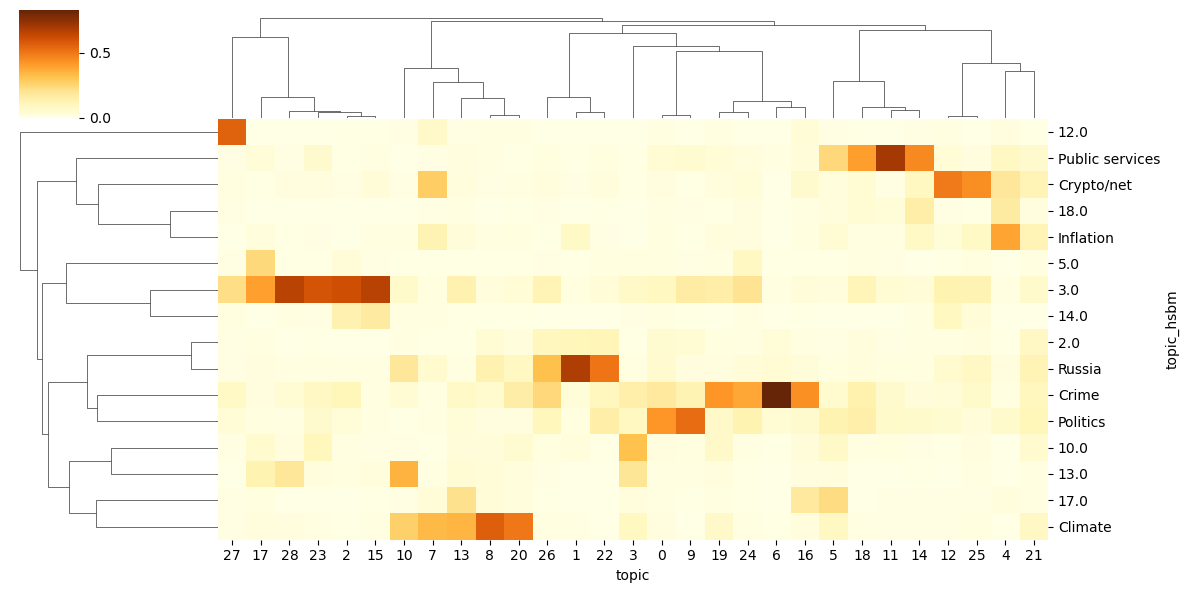

In [ ]:
# Share of each berttopic topic included in each hsbm topic (better overlap of named topics)
confusion = pd.crosstab(df["topic_hsbm"], df["topic"], normalize=1) 
cm = sns.clustermap(confusion, figsize=(12,6), cmap="YlOrBr", metric="cosine")#, vmax=1)

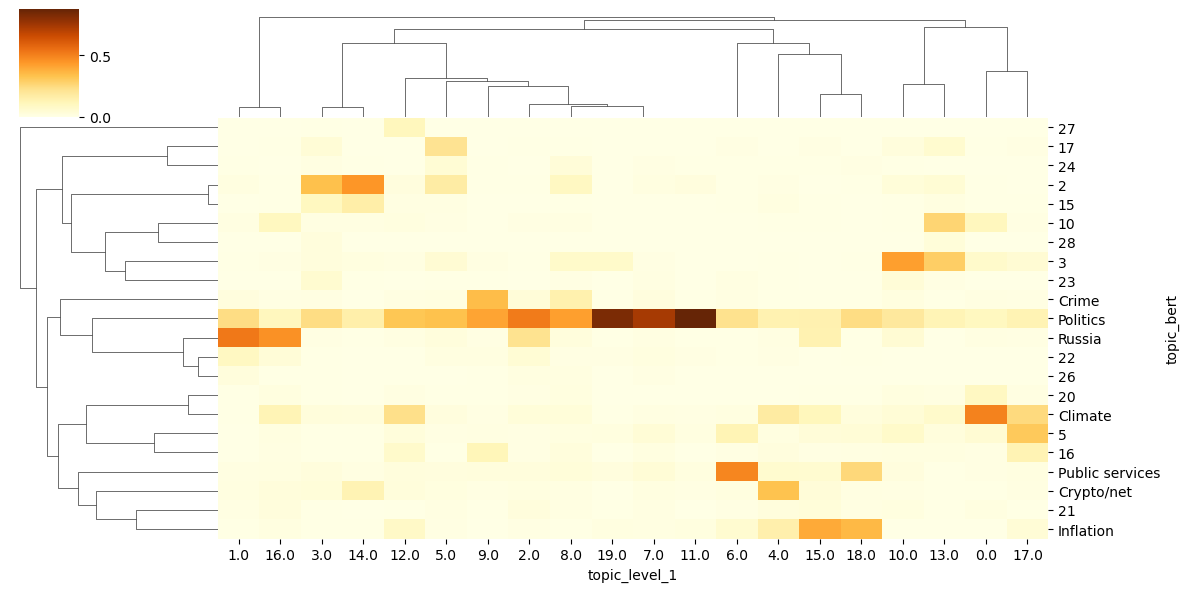

In [ ]:
# Share of each berttopic topic included in each hsbm topic  (better overlap of named topics)
confusion = pd.crosstab(df["topic_bert"], df["topic_level_1"], normalize=1) 
cm = sns.clustermap(confusion, figsize=(12,6), cmap="YlOrBr", metric="cosine")#, vmax=1)

In [ ]:
# Final count of the topics
df["final_topic"].value_counts()

                   36864
Politics            8349
Russia              2780
Public services     1879
Crime               1769
Climate             1743
Crypto/net           956
Inflation            927
3                    203
17                    14
2                     13
10                    11
5                      8
Name: final_topic, dtype: int64

# Validation study of the topics

Manual validation of a random of 100 posts from the HSBM and BERTopic methods.

Results:
* When both methods agree, manual annotation also agreed in 93% of cases.
* When both methods disagree, manual agreed with bertopic 34% of cases, hsbm in 26% of cases, neither in 39% of cases.

In [108]:
np.random.seed(42)
pd.set_option('display.max_colwidth', 500)
df.dropna().loc[(df["topic_hsbm"] != df["topic_bert"])].sample(100).to_csv("data_processing/compare_hsbm_bert_disagree.tsv", sep="\t")
df.dropna().loc[(df["topic_hsbm"] == df["topic_bert"]) & (df["topic_hsbm"] != "-1")].sample(100).to_csv("data_processing/compare_hsbm_bert_agree.tsv", sep="\t")

In [114]:
pd.read_csv("data_processing/compare_hsbm_bert_agree_labeled.tsv", sep="\t")["manual_label"].str.lower().value_counts()

y    93
m     5
n     2
Name: manual_label, dtype: int64

In [115]:
pd.read_csv("data_processing/compare_hsbm_bert_disagree_labeled.tsv", sep="\t")["manual_label"].str.lower().value_counts()

n       39
b       34
h       26
both     1
Name: manual_label, dtype: int64

In [ ]:
# Save final results for further analyses
df[["story_id","final_topic"]].to_csv("data_processing/stories_final_topics.tsv", sep="\t", index_label=None)